In [17]:
from files.utils.constants import *
from files.utils.utility_functions import *
%matplotlib inline

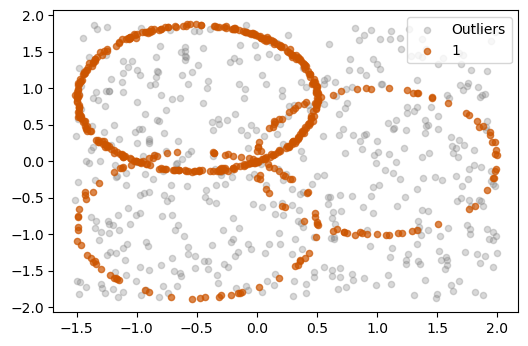

In [18]:
ds, gt = load_dataset_by_name(
    base_path="/home/catonz/Neural-PreferenceIsolation/", name="circle3")
plot_clusters(gt, ds)
x = np.linspace(np.min(ds[:, 0]), np.max(ds[:, 1]), len(ds))


In [19]:
from files.pif.pif import *

params = {
            "mss":2,
            "num_models": 500,
            "training_epochs": 300,
            "AE_structure": 
                {
                    "neurons": [2, 4, 2], 
                    "activation": torch.tanh
                }
            }

sac = PreferenceIsolationForest(data=ds, model_name=AE)
models_ithrs = sac.build_models(params=params)


--------------------------------------------------
Building RanSac models
Iteration 500/500: [==============================] (100%) ETA: 0:01:14.928899


Anomaly Detection
--------------------------------------------------
Not building models Pool because already generated.
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done


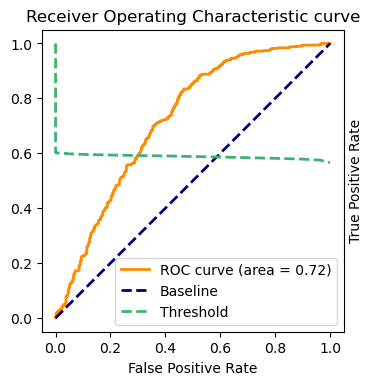

0.722218


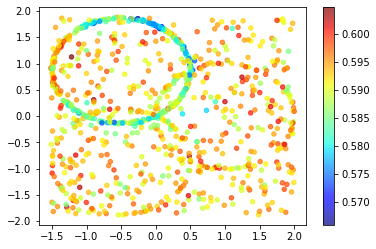

In [20]:
scores = sac.anomaly_detection(in_th=0.01)
auc, *_ = make_roc(gt, scores=scores, to_plot=False)

print(auc)
plot(ds, c=scores, cmap="jet")
plt.colorbar()


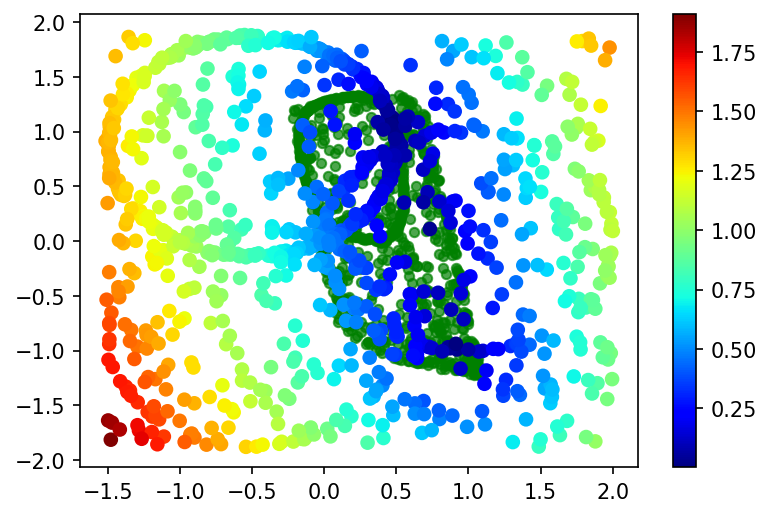

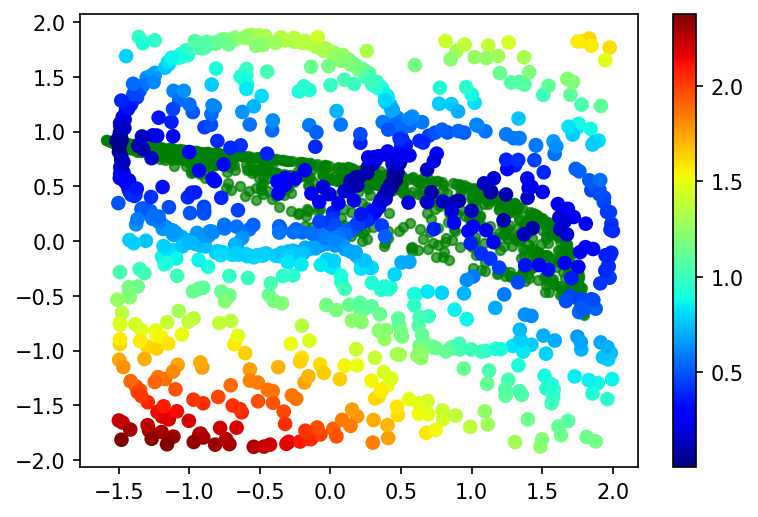

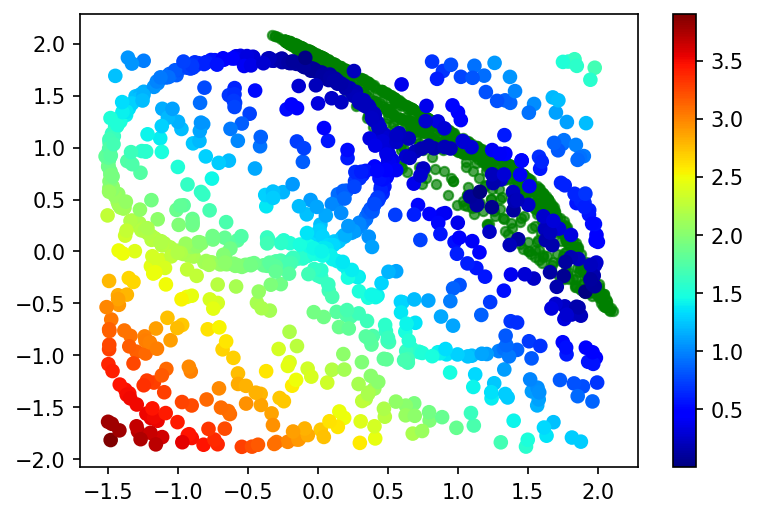

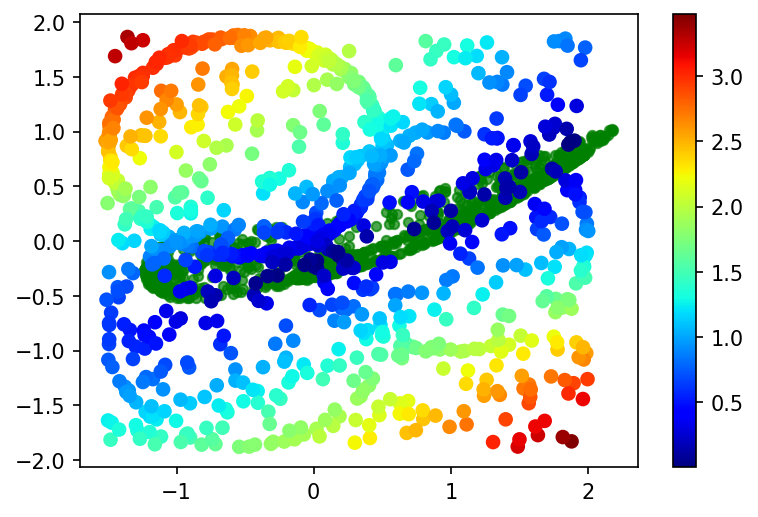

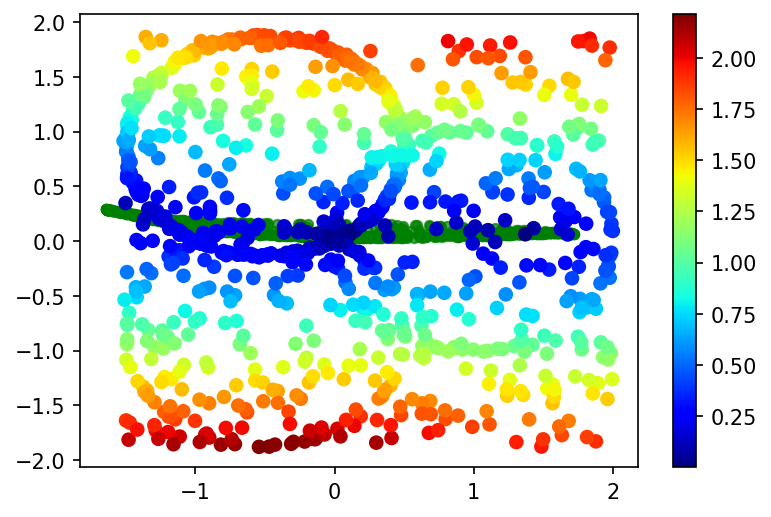

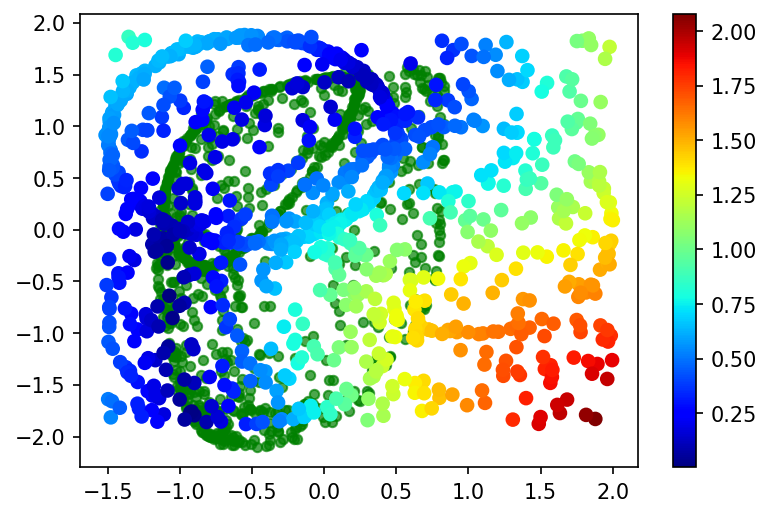

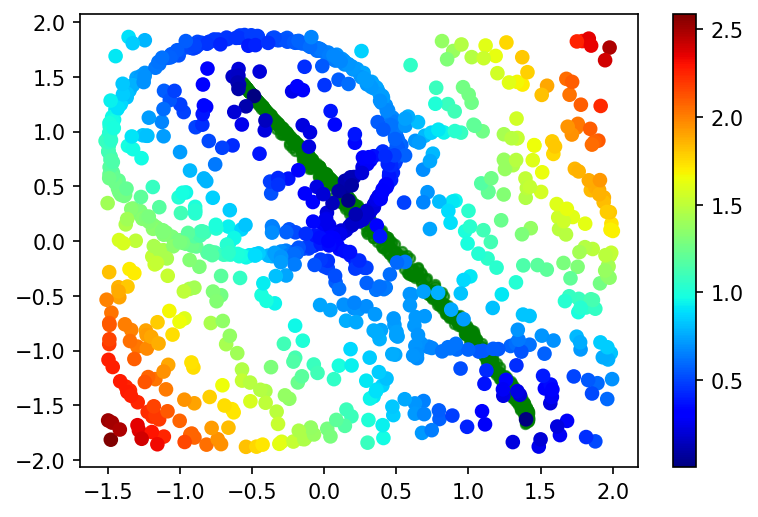

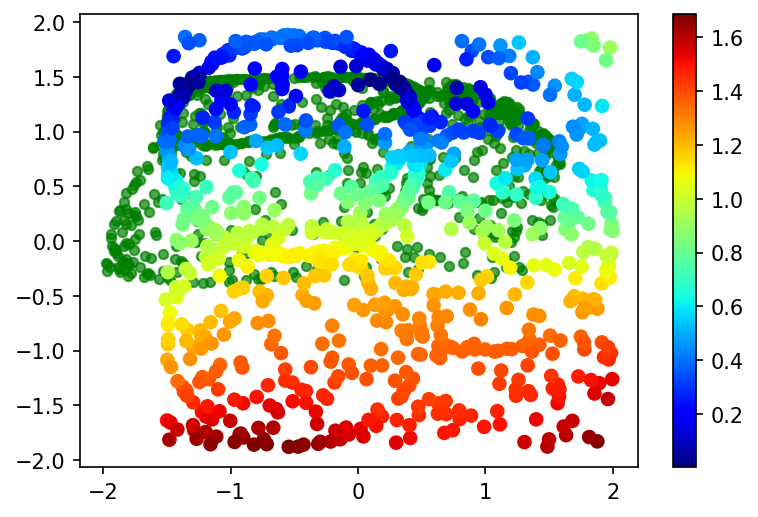

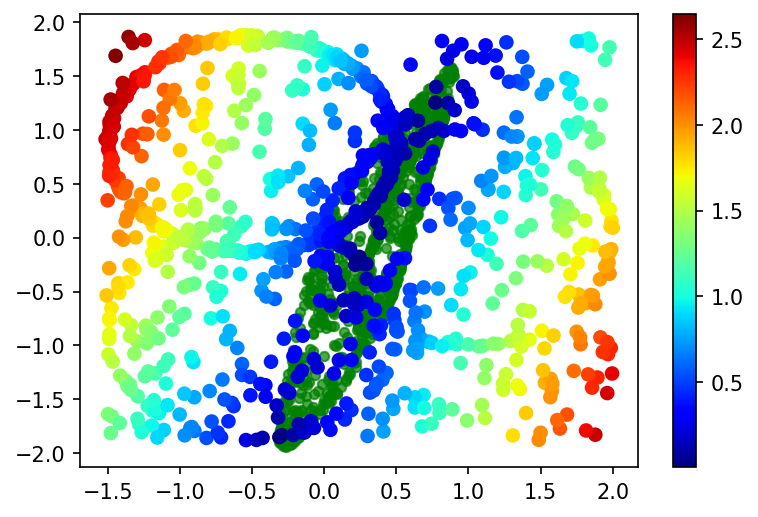

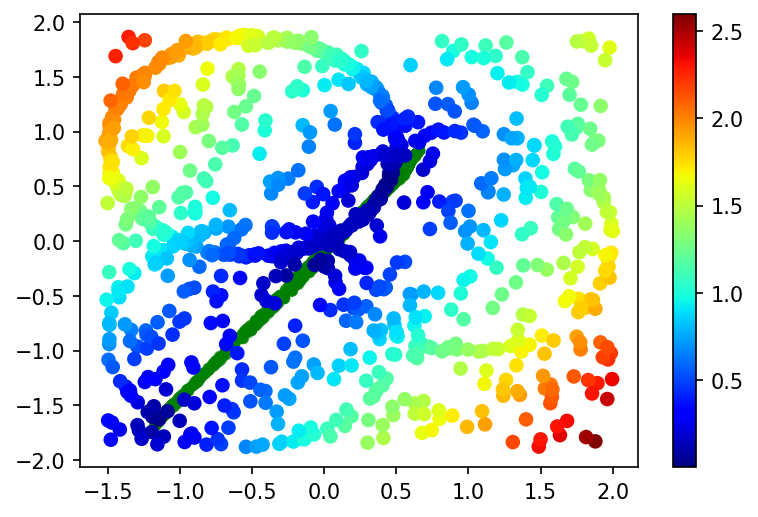

In [21]:
for i, model in enumerate(sac.models[:10]):
    scores = model.get_residuals(data=ds)
    plot(model.predict(ds), new_fig=True, c='g')
    plt.scatter(ds[:, 0], ds[:, 1], c=scores, cmap="jet")
    plt.colorbar()


from sklearn.ensemble import IsolationForest as iFor
from scipy.special import softmax
from sklearn.neighbors import LocalOutlierFactor as LOF
# %matplotlib off
plt.ioff()

ds_names = ["stair3", "stair4", "star5", "star11", "circle3", "circle4", "circle5"]
T = 1

lof_aucs, ifor_aucs = [], []
for ds_name in ds_names:
    ds, gt = load_dataset_by_name(
        base_path="/home/catonz/Neural-PreferenceIsolation/", name=ds_name)

    round_lof_aucs, round_ifor_aucs = [], []
    for i in range(T):
        lof = LOF(n_neighbors=20, contamination=0.5).fit(ds)
        scores = -lof.negative_outlier_factor_
        lof_auc, *_ = make_roc(gt, scores, show=False, to_plot=False);

        ifor = iFor().fit(ds)
        scores = -ifor.score_samples(ds)
        ifor_auc, *_ = make_roc(gt, scores, show=False, to_plot=False);

        round_lof_aucs.append(lof_auc)
        round_ifor_aucs.append(ifor_auc)

    lof_aucs.append(np.mean(round_lof_aucs))
    ifor_aucs.append(np.mean(round_ifor_aucs))


In [22]:
[(n, a) for n, a in zip(ds_names, lof_aucs)]

NameError: name 'ds_names' is not defined

In [ ]:
[(n, a) for n, a in zip(ds_names, ifor_aucs)]

[('stair3', 0.9388375),
 ('stair4', 0.895925),
 ('star5', 0.726592),
 ('star11', 0.7460297520661157),
 ('circle3', 0.7012959999999999),
 ('circle4', 0.6363),
 ('circle5', 0.569984)]